# <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> CS109B Data Science 2: Advanced Topics in Data Science 
## Homework 6 - RNNs



**Harvard University**<br/>
**Fall 2020**<br/>
**Instructors**: Mark Glickman, Pavlos Protopapas, & Chris Tanner


<hr style="height:2pt">

In [1]:
#RUN THIS CELL 
import requests
from IPython.core.display import HTML
styles = requests.get("https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/cs109.css").text
HTML(styles)

### INSTRUCTIONS

<span style="color:red">**Model training can be very slow; start doing this HW early**</span>

- To submit your assignment follow the instructions given in Canvas.

- This homework can be submitted in pairs.

- If you submit individually but you have worked with someone, please include the name of your **one** partner below.
- Please restart the kernel and run the entire notebook again before you submit.

**Names of person you have worked with goes here:**
<br><BR>

<div class="theme"> Overview: Named Entity Recognition Challenge</div>

Named entity recognition (NER) seeks to locate and classify named entities present in unstructured text into predefined categories such as organizations, locations, expressions of times, names of persons, etc. This technique is often used in real use cases such as classifying content for news providers, efficient search algorithms over large corpora and content-based recommendation systems. 

This represents an interesting "many-to-many" problem, allowing us to experiment with recurrent architectures and compare their performances against other models.


In [ ]:
import pandas as pd
import numpy as np

from sklearn.metrics import f1_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
plt.style.use("ggplot")

In [4]:
import tensorflow as tf

from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
# from tensorflow.keras import backend

# from tensorflow.keras.models import Model, Sequential,model_from_json
# from tensorflow.keras.layers import Input, SimpleRNN, Embedding, Dense, TimeDistributed, GRU, \
#                          Dropout, Bidirectional, Conv1D, BatchNormalization

print(tf.keras.__version__)
print(tf.__version__)

2.3.0-tf
2.2.0-rc3


In [ ]:
# Set seed for repeatable results
np.random.seed(123)
tf.random.set_seed(456)

<div class="theme"> Part 1: Data </div>
Read `HW6_data.csv` into a pandas dataframe using the provided code below.

In [6]:
# Given code
path_dataset = './data/HW6_data.csv'
data = pd.read_csv(path_dataset,
                   encoding="latin1")
data = data.fillna(method="ffill")
data.head(15)

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,Sentence: 1,of,IN,O
2,Sentence: 1,demonstrators,NNS,O
3,Sentence: 1,have,VBP,O
4,Sentence: 1,marched,VBN,O
5,Sentence: 1,through,IN,O
6,Sentence: 1,London,NNP,B-geo
7,Sentence: 1,to,TO,O
8,Sentence: 1,protest,VB,O
9,Sentence: 1,the,DT,O


As you can see, we have a dataset with sentences (```Sentence #``` column), each composed of words (```Word``` column) with part-of-speech tagging (```POS``` tagging) and inside–outside–beginning (IOB) named entity tags (```Tag``` column) attached. ```POS``` will not be used for this homework. We will predict ```Tag``` using only the words themselves.

Essential info about entities:
* geo = Geographical Entity
* org = Organization
* per = Person
* gpe = Geopolitical Entity
* tim = Time indicator
* art = Artifact
* eve = Event
* nat = Natural Phenomenon

IOB prefix:
* B: beginning of named entity
* I: inside of named entity
* O: outside of named entity


<div class='exercise'><b> Question 1: Data [20 points total]</b></div>

**1.1** Create a list of unique words found in the 'Word' column and sort it in alphabetic order. Then append the special word "ENDPAD" to the end of the list, and assign it to the variable ```words```. Store the length of this list as ```n_words```. **Print your results for `n_words`**

**1.2** Create a list of unique tags and sort it in alphabetic order. Then append the special word "PAD" to the end of the list, and assign it to the variable ```tags```. Store the length of this list as ```n_tags```. **Print your results for `n_tags`**

**1.3** Process the data into a list of sentences where each sentence is a list of (word, tag) tuples. Here is an example of how the first sentence in the list should look:

[('Thousands', 'O'),
 ('of',  'O'),
 ('demonstrators', 'O'),
 ('have', 'O'),
 ('marched', 'O'),
 ('through', 'O'),
 ('London', 'B-geo'),
 ('to', 'O'),
 ('protest', 'O'),
 ('the', 'O'),
 ('war', 'O'),
 ('in', 'O'),
 ('Iraq', 'B-geo'),
 ('and', 'O'),
 ('demand', 'O'),
 ('the', 'O'),
 ('withdrawal', 'O'),
 ('of', 'O'),
 ('British', 'B-gpe'),
 ('troops', 'O'),
 ('from', 'O'),
 ('that', 'O'),
 ('country', 'O'),
 ('.', 'O')]
 
**1.4** Find out the number of words in the longest sentence, and store it to variable ```max_len```. **Print your results for `max_len`.**

**1.5** It's now time to convert the sentences data in a suitable format for the RNNs training/evaluation procedures. Create a ```word2idx``` dictionary mapping distinct words from the dataset into distinct integers. Also create a ```idx2word``` dictionary.

**1.6** Prepare the predictors matrix ```X```, as a list of lists, where each inner list is a sequence of words mapped into integers accordly to the ```word2idx``` dictionary. 

**1.7** Apply the keras ```pad_sequences``` function to standardize the predictors. You should retrieve a matrix with all padded sentences and length equal to ```max_len``` previously computed. The dimensionality should therefore be equal to ```[# of sentences, max_len]```. Run the provided cell to print your results. Your ```X[i]``` now should be something similar to this:

`[ 8193 27727 31033 33289 22577 33464 23723 16665 33464 31142 31319 28267
 27700 33246 28646 16052    21 16915 17349  7924 32879 32985 18238 23555
    24 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178
 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178
 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178
 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178
 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178
 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178
 35178 35178 35178 35178 35178 35178 35178 35178]`
 
**1.8** Create a ```tag2idx``` dictionary mapping distinct named entity tags from the dataset into distinct integers. Also create a ```idx2tag``` dictionary.

**1.9** Prepare targets matrix ```Y```, as a list of lists,where each inner list is a sequence of tags mapped into integers accordly to the ```tag2idx``` dictionary.

**1.10** apply the keras ```pad_sequences``` function to standardize the targets. Inject the ```PAD``` tag for the padding words. You should retrieve a matrix with all padded sentences'tags and length equal to ```max_length``` previously computed. 

**1.11** Use the ```to_categorical``` keras function to one-hot encode the tags. Now your ```Y``` should have dimension ```[# of sentences, max_len, n_tags]```. Run the provided cell to print your results.

**1.12** Split the dataset into train and test sets (test 10%).

## Answers

**1.1** Create a list of unique words found in the 'Word' column and sort it in alphabetic order. Then append the special word "ENDPAD" to the end of the list, and assign it to the variable ```words```. Store the length of this list as ```n_words```. **Print your results for `n_words`**

In [7]:
# your code here
# Count number of words
words = sorted(list(set(data["Word"].values)))
words.append("ENDPAD")
n_words = len(words)
print(f'n_words: {n_words}')

n_words: 35179


In [8]:
# Run this cell to show your results for n_words
print(n_words)

35179


**1.2** Create a list of unique tags and sort it in alphabetic order. Then append the special word "PAD" to the end of the list, and assign it to the variable ```tags```. Store the length of this list as ```n_tags```. **Print your results for `n_tags`**

In [ ]:
# your code here
# Count number of tags
tags = sorted(list(set(data["Tag"].values)))
tags.append('PAD')
n_tags = len(tags)

In [10]:
# Run this cell to show your results for n_tags
print(n_tags)

18


**1.3** Process the data into a list of sentences where each sentence is a list of (word, tag) tuples. Here is an example of how the first sentence in the list should look:

In [ ]:
# your code here
# Get maximum sentence length as padding size
agg_func = lambda s: [(w, t) for w, t in zip(s["Word"].values.tolist(),s["Tag"].values.tolist())]
grouped = data.groupby("Sentence #").apply(agg_func)
sentences = [s for s in grouped]

**1.4** Find out the number of words in the longest sentence, and store it to variable ```max_len```. **Print your results for `max_len`.**

In [ ]:
# your code here
max_len = max([len(s) for s in sentences])

In [13]:
# Run this cell to show your results for max_len
print(max_len)

104


**1.5** It's now time to convert the sentences data in a suitable format for the RNNs training/evaluation procedures. Create a ```word2idx``` dictionary mapping distinct words from the dataset into distinct integers. Also create a ```idx2word``` dictionary.

In [ ]:
# your code here
# Create dictionary to map words to integers
word2idx = {w: i for i, w in enumerate(words)}
idx2word = {i: w for i, w in enumerate(words)}

**1.6** Prepare the predictors matrix ```X```, as a list of lists, where each inner list is a sequence of words mapped into integers accordly to the ```word2idx``` dictionary.

In [ ]:
# your code here
# Prepare predictors list of lists
X = [[word2idx[w[0]] for w in s] for s in sentences]

**1.7** Apply the keras ```pad_sequences``` function to standardize the predictors. You should retrieve a matrix with all padded sentences and length equal to ```max_len``` previously computed. The dimensionality should therefore be equal to ```[# of sentences, max_len]```. Run the provided cell to print your results. Your ```X[i]``` now should be something similar to this:

In [ ]:
# your code here
# Apply the keras pad_sequences function
X = pad_sequences(maxlen=max_len, sequences=X, padding="post", value=n_words-1)

In [17]:
# Run this cell to show your results #
print("The index of word 'Harvard' is: {}\n".format(word2idx["Harvard"]))
print("Sentence 1: {}\n".format(X[1]))
print(X.shape)

The index of word 'Harvard' is: 7506

Sentence 1: [ 8193 27727 31033 33289 22577 33464 23723 16665 33464 31142 31319 28267
 27700 33246 28646 16052    21 16915 17349  7924 32879 32985 18238 23555
    24 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178
 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178
 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178
 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178
 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178
 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178
 35178 35178 35178 35178 35178 35178 35178 35178]

(47959, 104)


**1.8** Create a ```tag2idx``` dictionary mapping distinct named entity tags from the dataset into distinct integers. Also create a ```idx2tag``` dictionary.

In [ ]:
# your code here
# Create dictionary to map tags to integers
tag2idx = {t: i for i, t in enumerate(tags)}
idx2tag = {i: t for i, t in enumerate(tags)}

**1.9** Prepare targets matrix ```Y```, as a list of lists,where each inner list is a sequence of tags mapped into integers accordly to the ```tag2idx``` dictionary.

In [ ]:
# your code here
# Prepare targets list of lists
y = [[tag2idx[w[1]] for w in s] for s in sentences]

**1.10** apply the keras ```pad_sequences``` function to standardize the targets. Inject the ```PAD``` tag for the padding words. You should retrieve a matrix with all padded sentences'tags and length equal to ```max_length``` previously computed.

In [ ]:
# your code here
# Apply the kera pas_sequences function
y = pad_sequences(maxlen=max_len, sequences=y, padding="post", value=tag2idx["PAD"])

**1.11** Use the ```to_categorical``` keras function to one-hot encode the tags. Now your ```Y``` should have dimension ```[# of sentences, max_len, n_tags]```. Run the provided cell to print your results.

In [ ]:
# your code here
# Onehot encode target variable
y = [to_categorical(i, num_classes=n_tags) for i in y]

In [22]:
# Run this cell to show your results #
print("The index of tag 'B-gpe' is: {}\n".format(tag2idx["B-gpe"]))
print("The tag of the last word in Sentence 1: {}\n".format(y[0][-1]))
print(np.array(y).shape)

The index of tag 'B-gpe' is: 3

The tag of the last word in Sentence 1: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]

(47959, 104, 18)


**1.12** Split the dataset into train and test sets (test 10%).

In [ ]:
# your code here
# Split train/test datasets
X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.1, shuffle=True)
y_tr, y_te = np.array(y_tr), np.array(y_te)

## Part 2: Modelling

After preparing the train and test sets, we are ready to build five models: 
* frequency-based baseline 
* vanilla feedforward neural network
* recurrent neural network
* gated recurrent neural network
* bidirectional gated recurrent neural network

More details are given about architecture in each model's section. The input/output dimensionalities will be the same for all models:
* input: ```[# of sentences, max_len]```
* output: ```[# of sentences, max_len, n_tags]```

Follow the information in each model's section to set up the architecture of each model. And the end of each training, use the given ```store_model``` function to store the weights and architectures in the ```./models``` path for later testing;```load_keras_model()``` is also provided to you

A further ```plot_training_history``` helper function is given in case you need to check the training history.


In [ ]:
# Store model
def store_keras_model(model, model_name):
    model_json = model.to_json() # serialize model to JSON
    with open("./models/{}.json".format(model_name), "w") as json_file:
        json_file.write(model_json)
    model.save_weights("./models/{}.h5".format(model_name)) # serialize weights to HDF5
    print("Saved model to disk")
    
# Plot history
def plot_training_history(history):
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1,len(loss)+1)

    plt.figure()
    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('epoch')
    plt.legend()
    plt.show()

In [ ]:
# Load model 
def load_keras_model(model_name):
    # Load json and create model
    json_file = open('./models/{}.json'.format(model_name), 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    model = tf.keras.models.model_from_json(loaded_model_json)
    # Load weights into new model
    model.load_weights("./models/{}.h5".format(model_name))
    return model

<div class='exercise'><b>Question 2: Models [40 points total]</b></div>

**2.1** **Model 1: Baseline Model**

Predict the tag of a word simply with the most frequently-seen named entity tag of this word from the training set.

e.g. word "Apple" appears 10 times in the training set; 7 times it was tagged as "Corporate" and 3 times it was tagged as "Fruit". If we encounter the word "Apple" in the test set, we predict it as "Corporate".

**Create an np.array ```baseline``` of length [n_words]**
where the ith element   ```baseline[i]``` is the index of the most commonly seen named entity tag of word i summarised from training set.   (e.g. [16, 16, 16, ..., 0, 16, 16])


**2.2** **Model 2: Vanilla Feed Forward Neural Network**

This model is provided for you. Please pay attention to the architecture of this neural network, especially the input/output dimensionalities and the Embedding layer.


**2.2a** Explain what the embedding layer is and why we need it here.

**2.2b** Explain why the Param # of Embedding layer is 1758950 (as shown in `print(model.summary())`).

**2.3** **Model 3: RNN**

Set up a simple RNN model by stacking the following layers in sequence:

    an input layer
    a simple Embedding layer transforming integer words into vectors
    a dropout layer to regularize the model
    a SimpleRNN layer
    a TimeDistributed layer with an inner Dense layer which output dimensionality is equal to n_tag
    
*(For hyperparameters, use those provided in Model 2)*

**2.3a** Define, compile, and train an RNN model. Use the provided code to save the model and plot the training history.

**2.3b** Visualize outputs from the SimpleRNN layer, one subplot for B-tags and one subplot for I-tags. Comment on the patterns you observed.

**2.4** **Model 4: GRU**

**2.4a** Briefly explain what a GRU is and how it's different from a simple RNN.

**2.4b** Define, compile, and train a GRU architecture by replacing the SimpleRNN cell with a GRU one. Use the provided code to save the model and plot the training history.

**2.4c** Visualize outputs from GRU layer, one subplot for **B-tags** and one subplot for **I-tags**. Comment on the patterns you observed.

**2.5** **Model 5: Bidirectional GRU**

**2.5a** Explain how a Bidirectional GRU differs from GRU model above.

**2.5b** Define, compile, and train a bidirectional GRU by wrapping your GRU layer in a Bidirectional one. Use the provided code to save the model and plot the training history.

**2.5c** Visualize outputs from bidirectional GRU layer, one subplot for **B-tags** and one subplot for **I-tags**. Comment on the patterns you observed.

## Answers

**2.1** **Model 1: Baseline Model**

In [26]:
# your code here
class CounterModel:
    
    def __init__(self):
        pass
    
    def fit(self, X_tr, y_tr, n_words, n_tags):
        self.dict_np = np.zeros(shape=(n_words,n_tags))
        for sentence in range(X_tr.shape[0]):
            for word in range(X_tr.shape[1]):
                self.dict_np[X_tr[sentence,word],:] += y_tr[sentence,word,:] 
        unseen_index = np.sum(self.dict_np,axis=1)==0
        self.dict_np = np.argmax(self.dict_np, axis=1)
        self.dict_np[unseen_index]=tag2idx['O']
        
    def predict(self, X_te, batch_size=None):
        return np.array([idx2tag[i] for i in self.dict_np[X_te]])


model = CounterModel()
model.fit(X_tr, y_tr, n_words, n_tags)
baseline = model.dict_np
model.predict(X[0])

array(['O', 'O', 'O', 'O', 'O', 'O', 'B-geo', 'O', 'O', 'O', 'O', 'O',
       'B-geo', 'O', 'O', 'O', 'O', 'O', 'B-gpe', 'O', 'O', 'O', 'O', 'O',
       'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD',
       'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD',
       'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD',
       'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD',
       'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD',
       'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD',
       'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD',
       'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD',
       'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD'],
      dtype='<U5')

In [27]:
# Run this cell to show your results #

print(baseline[X].shape,'\n')
print('Sentence:\n {}\n'.format([idx2word[w] for w in X[0]]))
print('Predicted Tags:\n {}'.format([idx2tag[i] for i in baseline[X[0]]]))

(47959, 104) 

Sentence:
 ['Thousands', 'of', 'demonstrators', 'have', 'marched', 'through', 'London', 'to', 'protest', 'the', 'war', 'in', 'Iraq', 'and', 'demand', 'the', 'withdrawal', 'of', 'British', 'troops', 'from', 'that', 'country', '.', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDP

**2.2** **Model 2: Vanilla Feed Forward Neural Network**

### Use these hyperparameters for all NN models

In [ ]:
n_units = 100
drop_rate = .1
dim_embed = 50

optimizer = "rmsprop"
loss = "categorical_crossentropy"
metrics = ["accuracy"]

batch_size = 32
epochs = 10
validation_split = 0.1
verbose = 1

In [ ]:
# Define model
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(input_dim=n_words, output_dim=dim_embed, input_length=max_len))
model.add(tf.keras.layers.Dropout(drop_rate))
model.add(tf.keras.layers.Dense(n_tags, activation="softmax"))

# Compile model
model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [30]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 104, 50)           1758950   
_________________________________________________________________
dropout (Dropout)            (None, 104, 50)           0         
_________________________________________________________________
dense (Dense)                (None, 104, 18)           918       
Total params: 1,759,868
Trainable params: 1,759,868
Non-trainable params: 0
_________________________________________________________________
None


In [31]:
# Train model
history = model.fit(X_tr, y_tr, batch_size=batch_size, epochs=epochs, 
                    validation_split=validation_split, verbose=verbose)

Epoch 1/10
1214/1214 [==============================] - 11s 9ms/step - loss: 0.3148 - accuracy: 0.9787 - val_loss: 0.0602 - val_accuracy: 0.9858
Epoch 2/10
1214/1214 [==============================] - 10s 9ms/step - loss: 0.0514 - accuracy: 0.9863 - val_loss: 0.0477 - val_accuracy: 0.9868
Epoch 3/10
1214/1214 [==============================] - 11s 9ms/step - loss: 0.0451 - accuracy: 0.9872 - val_loss: 0.0448 - val_accuracy: 0.9875
Epoch 4/10
1214/1214 [==============================] - 10s 9ms/step - loss: 0.0428 - accuracy: 0.9877 - val_loss: 0.0435 - val_accuracy: 0.9878
Epoch 5/10
1214/1214 [==============================] - 11s 9ms/step - loss: 0.0415 - accuracy: 0.9881 - val_loss: 0.0428 - val_accuracy: 0.9880
Epoch 6/10
1214/1214 [==============================] - 10s 9ms/step - loss: 0.0407 - accuracy: 0.9883 - val_loss: 0.0423 - val_accuracy: 0.9882
Epoch 7/10
1214/1214 [==============================] - 11s 9ms/step - loss: 0.0401 - accuracy: 0.9885 - val_loss: 0.0419 - val_ac

In [32]:
store_keras_model(model, 'model_FFNN')

Saved model to disk


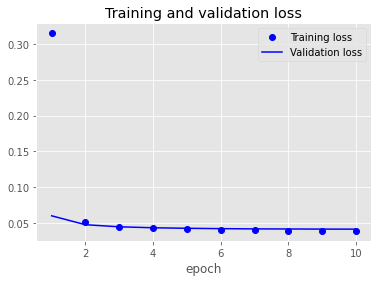

In [33]:
plot_training_history(history)

**2.2a** Explain what the embedding layer is and why we need it here.

*your answer here*

An embedding is a linear projection from one vector space to another. We usually use embeddings to project the one-hot encodings of words on to a lower-dimensional continuous space so that the input surface is dense and possibly smooth. 

**2.2b** Explain why the Param # of Embedding layer is 1758950 (as shown in `print(model.summary())`).

*your answer here*

We have a vocabulary of size 35179 that we are trying to reduce to 50 dimensions. This means that we want $35179 \times 50 = 1758950$ weights, 1 for the correspondence between each word in the vocabulary to each dimension in the embedding space.

### Viewing Hidden Layers
In addition to the final result, we also want to see the intermediate results from hidden layers. Below is an example showing how to get outputs from a hidden layer, and visualize them on the reduced dimension of 2D by PCA. (**Please note that this code and the parameters cannot be simply copied and pasted for other questions; some adjustments need to be made**) 

In [34]:
FFNN = load_keras_model("model_FFNN")
def create_truncated_model_FFNN(trained_model):
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Embedding(input_dim=n_words, output_dim=dim_embed, input_length=max_len))
    model.add(tf.keras.layers.Dropout(drop_rate))
    # set weights of first few layers using the weights of trained model
    for i, layer in enumerate(model.layers):
        layer.set_weights(trained_model.layers[i].get_weights())
    model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
    return model
truncated_model = create_truncated_model_FFNN(FFNN)
hidden_features = truncated_model.predict(X_te)

# flatten data
hidden_features = hidden_features.reshape(-1,50)
 
# find first two PCA components
pca = PCA(n_components=2)
pca_result = pca.fit_transform(hidden_features)
print('Variance explained by PCA: {}'.format(np.sum(pca.explained_variance_ratio_)))

Variance explained by PCA: 0.943623696759107


**Code corrected in `visualize_hidden_features(pca_result)`**
The code in the following function has been corrected as per [this Ed post](https://us.edstem.org/courses/172/discussion/23731).

In [ ]:
# visualize hidden featurs on first two PCA components
# this plot only shows B-tags
def visualize_hidden_features(pca_result):
    color=['r', 'C1', 'y', 'C3', 'b', 'g', 'm', 'orange']
    category = np.argmax(y_te.reshape(-1,18), axis=1)
    fig, ax = plt.subplots()
    fig.set_size_inches(6,6)    
    for cat in range(8):
        indices_B = np.where(category==cat)[0]
        #length=min(1000,len(indices_B))
        #indices_B=indices_B[:length]
        ax.scatter(pca_result[indices_B,0], pca_result[indices_B, 1], label=idx2tag[cat],s=2,color=color[cat],alpha=0.5)
        legend=ax.legend(markerscale=3)
        legend.get_frame().set_facecolor('w')  
    plt.show()

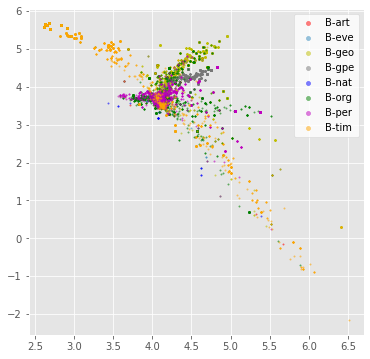

In [36]:
visualize_hidden_features(pca_result)

### Full function for other questions ###

In [ ]:
def get_hidden_output_PCA(model,X_te,y_te,layer_index,out_dimension):
    output = tf.keras.backend.function([model.layers[0].input],[model.layers[layer_index].output])
    hidden_feature=np.array(output([X_te]))
    hidden_feature=hidden_feature.reshape(-1,out_dimension)
    
    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(hidden_feature)
    print('Variance explained by PCA: {}'.format(np.sum(pca.explained_variance_ratio_)))
    return pca_result

In [ ]:
def visualize_B_I(pca_result):
    color = ['r', 'C1', 'y', 'C3', 'b', 'g', 'm', 'orange']
    category = np.argmax(y_te.reshape(-1,18), axis=1)
    fig, ax = plt.subplots(1,2) 
    fig.set_size_inches(12,6)
    for i in range(2):
        for cat in range(8*i,8*(i+1)):
            indices = np.where(category==cat)[0]
            ax[i].scatter(pca_result[indices,0], pca_result[indices, 1], label=idx2tag[cat],s=2,color=color[cat-8*i],alpha=0.5)
        legend = ax[i].legend(markerscale=3)
        legend.get_frame().set_facecolor('w') 
        ax[i].set_xlabel("first dimension")
        ax[i].set_ylabel("second dimension")
    fig.suptitle("visualization of hidden feature on reduced dimension by PCA")
    
    plt.show()

Variance explained by PCA: 0.9436237920566144


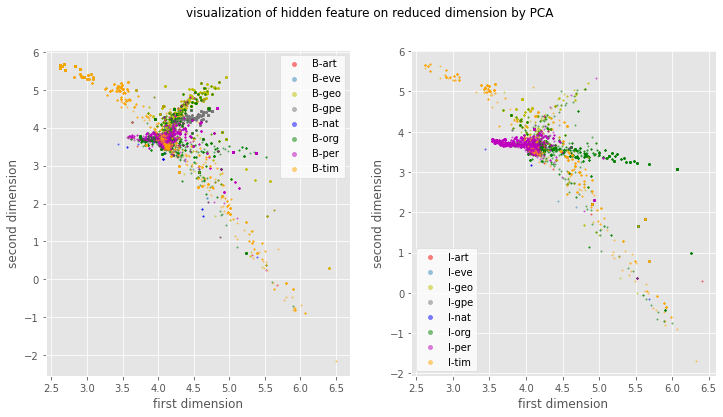

In [39]:
h = get_hidden_output_PCA(FFNN,X_te,y_te,1,50)
visualize_B_I(h)

**2.3** **Model 3: RNN**

**2.3a** Define, compile, and train an RNN model. Use the provided code to save the model and plot the training history.

In [40]:
# your code here
# Define model
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(input_dim=n_words, output_dim=dim_embed, input_length=max_len))
model.add(tf.keras.layers.Dropout(drop_rate))
model.add(tf.keras.layers.SimpleRNN(units=n_units, return_sequences=True))
model.add(tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(n_tags, activation="softmax")))

# Compile model
model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

# Train model
history = model.fit(X_tr, y_tr, batch_size=batch_size, epochs=epochs, 
                    validation_split=validation_split, verbose=verbose)

Epoch 1/10
1214/1214 [==============================] - 88s 73ms/step - loss: 0.0883 - accuracy: 0.9781 - val_loss: 0.0326 - val_accuracy: 0.9903
Epoch 2/10
1214/1214 [==============================] - 87s 71ms/step - loss: 0.0295 - accuracy: 0.9912 - val_loss: 0.0286 - val_accuracy: 0.9915
Epoch 3/10
1214/1214 [==============================] - 91s 75ms/step - loss: 0.0262 - accuracy: 0.9922 - val_loss: 0.0275 - val_accuracy: 0.9917
Epoch 4/10
1214/1214 [==============================] - 90s 74ms/step - loss: 0.0244 - accuracy: 0.9927 - val_loss: 0.0271 - val_accuracy: 0.9919
Epoch 5/10
1214/1214 [==============================] - 93s 77ms/step - loss: 0.0231 - accuracy: 0.9931 - val_loss: 0.0270 - val_accuracy: 0.9919
Epoch 6/10
1214/1214 [==============================] - 92s 76ms/step - loss: 0.0222 - accuracy: 0.9934 - val_loss: 0.0267 - val_accuracy: 0.9919
Epoch 7/10
1214/1214 [==============================] - 91s 75ms/step - loss: 0.0213 - accuracy: 0.9936 - val_loss: 0.0264 -

In [41]:
# save your mode ##
store_keras_model(model, 'model_RNN')

Saved model to disk


In [42]:
# run this cell to show your results #
print(model.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 104, 50)           1758950   
_________________________________________________________________
dropout_2 (Dropout)          (None, 104, 50)           0         
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, 104, 100)          15100     
_________________________________________________________________
time_distributed (TimeDistri (None, 104, 18)           1818      
Total params: 1,775,868
Trainable params: 1,775,868
Non-trainable params: 0
_________________________________________________________________
None


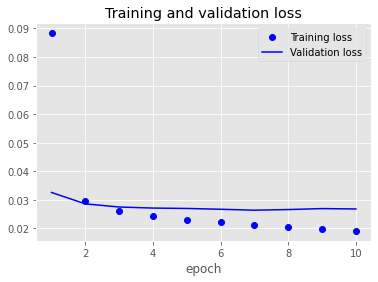

In [43]:
# run this cell to show your results #
plot_training_history(history)

**2.3b** Visualize outputs from the SimpleRNN layer, one subplot for B-tags and one subplot for I-tags. Comment on the patterns you observed.

Variance explained by PCA: 0.8492897091391686


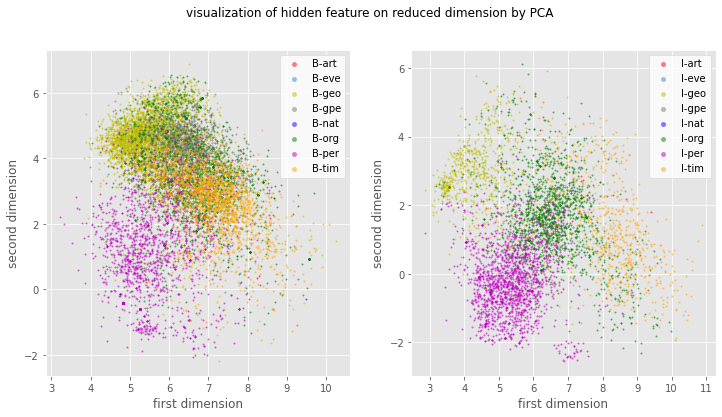

In [44]:
# your code here
# visualization of hidden features
RNN = load_keras_model('model_RNN')
h = get_hidden_output_PCA(RNN,X_te,y_te,2,100)
visualize_B_I(h)

*your answers here*

In general, the projection is more 'spread out', in the sense that the points representing entries in our training data tend not to have outliers in the first and second dimension spce.

**B-Tags**

There are some improvements in the B-tag PCA compared to the FFNN. In particular, the purple B-per class is better separated from the rest of the groups (such as the green B-geo and B-org clusters) compared to the FFNN, but B-tim has significant overlap with B-geo and B-org that was not as prominent in the visualization of the FFNN.

**I-Tags**

The I-tags are better separated compared to the B tags. In particular, the purple I-per tag is relatively well separated from the I-org and I-geo tags. However, there is still significant overlap, for example, between the I-org and I-tim tags. Compared to the FFNN, it is hard to say whether there is significant change based purely on the visualization alone.

**Variance Explained**

Variance explained has decreased compared to the FFNN from higher than 94% to around 85%.

<div class='explication'> </div>

**2.4** **Model 4: GRU**

**2.4a** Briefly explain what a GRU is and how it's different from a simple RNN.

*your answer here*

A Gated Recurrent Unit (GRU) is an enhancement of RNNs, which add gates LSTM and GRU are two sophisticated implementations of RNNs that have gates. A gate emits probability between 0 and 1.

**Gates Modelling Information Decay**

The gates effectively more explicitly model the manner in which past information can affect the current time period's output. Rather than just having the hidden state (which contains past information, and under a Markov assumption can be assumed to include the sum total of all past information) enter the output through concatenation (as in an RNN) before activation, we have the hidden state interact with the current information in different proportions through update and reset gates.

Since we explicitly allow for a greater degree of interaction between the hidden (past) state and current state, we are able to allow for a more flexible class of models.

**2.4b** Define, compile, and train a GRU architecture by replacing the SimpleRNN cell with a GRU one. Use the provided code to save the model and plot the training history.

In [45]:
# your code here
# Define model
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(input_dim=n_words, output_dim=dim_embed, input_length=max_len))
model.add(tf.keras.layers.Dropout(drop_rate))
model.add(tf.keras.layers.GRU(units=n_units, return_sequences=True))
model.add(tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(n_tags, activation="softmax")))

# Compile model
model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

# Train model
history = model.fit(X_tr, y_tr, batch_size=batch_size, epochs=epochs, 
                    validation_split=validation_split, verbose=verbose)

Epoch 1/10
1214/1214 [==============================] - 18s 15ms/step - loss: 0.0894 - accuracy: 0.9776 - val_loss: 0.0321 - val_accuracy: 0.9904
Epoch 2/10
1214/1214 [==============================] - 18s 15ms/step - loss: 0.0291 - accuracy: 0.9913 - val_loss: 0.0281 - val_accuracy: 0.9916
Epoch 3/10
1214/1214 [==============================] - 17s 14ms/step - loss: 0.0259 - accuracy: 0.9923 - val_loss: 0.0270 - val_accuracy: 0.9920
Epoch 4/10
1214/1214 [==============================] - 17s 14ms/step - loss: 0.0242 - accuracy: 0.9928 - val_loss: 0.0265 - val_accuracy: 0.9921
Epoch 5/10
1214/1214 [==============================] - 17s 14ms/step - loss: 0.0229 - accuracy: 0.9932 - val_loss: 0.0263 - val_accuracy: 0.9922
Epoch 6/10
1214/1214 [==============================] - 17s 14ms/step - loss: 0.0219 - accuracy: 0.9934 - val_loss: 0.0260 - val_accuracy: 0.9922
Epoch 7/10
1214/1214 [==============================] - 18s 14ms/step - loss: 0.0211 - accuracy: 0.9937 - val_loss: 0.0256 -

In [46]:
# save your model #
store_keras_model(model, 'model_GRU')

Saved model to disk


In [47]:
# run this cell to show your results #
print(model.summary())

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 104, 50)           1758950   
_________________________________________________________________
dropout_3 (Dropout)          (None, 104, 50)           0         
_________________________________________________________________
gru (GRU)                    (None, 104, 100)          45600     
_________________________________________________________________
time_distributed_1 (TimeDist (None, 104, 18)           1818      
Total params: 1,806,368
Trainable params: 1,806,368
Non-trainable params: 0
_________________________________________________________________
None


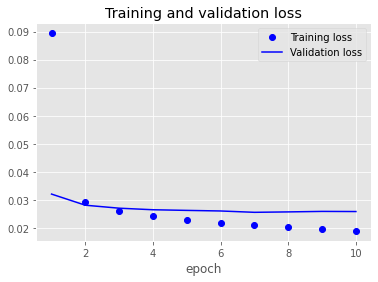

In [48]:
# run this cell to show your results #
plot_training_history(history)

**2.4c** Visualize outputs from GRU layer, one subplot for **B-tags** and one subplot for **I-tags**. Comment on the patterns you observed.

Variance explained by PCA: 0.7586709362101896


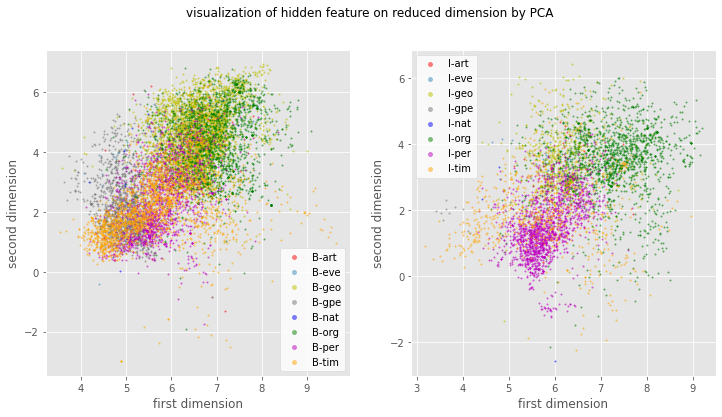

In [49]:
# your code here
# visualization of hidden features
GRU=load_keras_model('model_GRU')
h=get_hidden_output_PCA(GRU,X_te,y_te,2,100)
visualize_B_I(h)

*your answer here*

**B-Tags**

The B-tags are much improved compared to the FFNN and the RNN. Here, we can see the separation of B-gpe from all other classes, and even though there is some oeverlap between B-geo and B-org, it seems like B-geo in general is well separated from the remaining tags.

However, there is still significant overlap between the purple B-per and B-tim.

**I-Tags**

The I-tags do not show significant improvement. Even though the I-org and I-per tags are in general separated from each other very well, and separated from I-geo as well, there is still significant overlap between I-per and I-tim

**Variance Explained**

The variance explained is lower than the FFNN and the RNN despite having better (visual) separation.

**2.5** **Model 5: Bidirectional GRU**

**2.5a** Explain how a Bidirectional GRU differs from GRU model above.

*your answer here*

In a unidirectional GRU, we only allow the past state to influence the current state. In a bidirectional GRU, we allow the current state to be dependent on the future as well as the past.

This is an advantage in language processing, since context can happen after the word as well as before, depending on the sentence structure and grammar of the language being considered.

**2.5b** Define, compile, and train a bidirectional GRU by wrapping your GRU layer in a Bidirectional one. Use the provided code to save the model and plot the training history.

In [50]:
# your code here
# Define model
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(input_dim=n_words, output_dim=dim_embed, input_length=max_len))
model.add(tf.keras.layers.Dropout(drop_rate))
model.add(tf.keras.layers.Bidirectional(tf.keras.layers.GRU(units=n_units, return_sequences=True)))
model.add(tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(n_tags, activation="softmax")))

# Compile model
model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

# Train model
history = model.fit(X_tr, y_tr, batch_size=batch_size, epochs=epochs, 
                    validation_split=validation_split, verbose=verbose)

Epoch 1/10
1214/1214 [==============================] - 23s 19ms/step - loss: 0.0724 - accuracy: 0.9818 - val_loss: 0.0276 - val_accuracy: 0.9920
Epoch 2/10
1214/1214 [==============================] - 24s 20ms/step - loss: 0.0241 - accuracy: 0.9929 - val_loss: 0.0238 - val_accuracy: 0.9930
Epoch 3/10
1214/1214 [==============================] - 24s 20ms/step - loss: 0.0208 - accuracy: 0.9939 - val_loss: 0.0225 - val_accuracy: 0.9934
Epoch 4/10
1214/1214 [==============================] - 23s 19ms/step - loss: 0.0189 - accuracy: 0.9944 - val_loss: 0.0221 - val_accuracy: 0.9934
Epoch 5/10
1214/1214 [==============================] - 23s 19ms/step - loss: 0.0175 - accuracy: 0.9948 - val_loss: 0.0219 - val_accuracy: 0.9936
Epoch 6/10
1214/1214 [==============================] - 24s 19ms/step - loss: 0.0164 - accuracy: 0.9951 - val_loss: 0.0221 - val_accuracy: 0.9934
Epoch 7/10
1214/1214 [==============================] - 23s 19ms/step - loss: 0.0155 - accuracy: 0.9954 - val_loss: 0.0217 -

In [51]:
# save your model #
store_keras_model(model, 'model_BiGRU')

Saved model to disk


In [52]:
# run this cell to show your results #
print(model.summary())

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 104, 50)           1758950   
_________________________________________________________________
dropout_4 (Dropout)          (None, 104, 50)           0         
_________________________________________________________________
bidirectional (Bidirectional (None, 104, 200)          91200     
_________________________________________________________________
time_distributed_2 (TimeDist (None, 104, 18)           3618      
Total params: 1,853,768
Trainable params: 1,853,768
Non-trainable params: 0
_________________________________________________________________
None


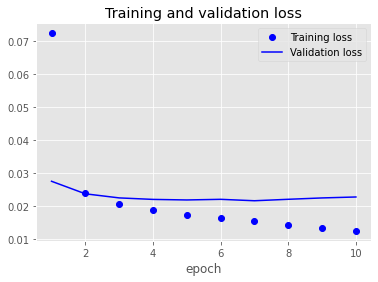

In [53]:
# run this cell to show your results #
plot_training_history(history)

**2.5c** Visualize outputs from bidirectional GRU layer, one subplot for **B-tags** and one subplot for **I-tags**. Comment on the patterns you observed.

Variance explained by PCA: 0.7947165374976546


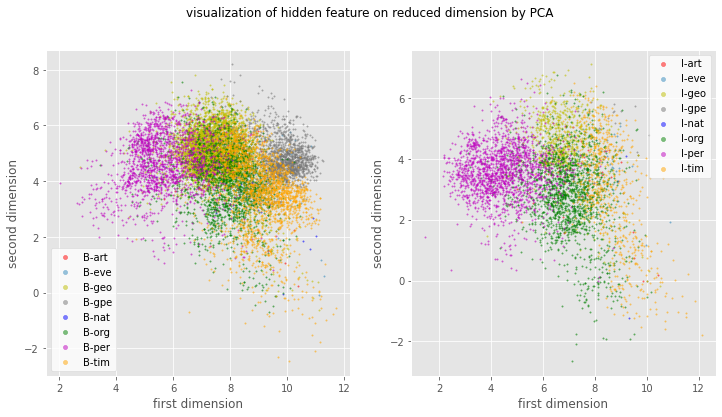

In [54]:
# your code here
# visualization of hidden features
BiGRU = load_keras_model('model_BiGRU')
h = get_hidden_output_PCA(BiGRU,X_te,y_te,2,200)
visualize_B_I(h)

*your answer here*

**B-Tag: Poorer Separation than GRU Model**

The separation between the purple B-per tags and the two green B-org and B-geo tags is clear. However, unlike the unidirectional GRU, we do not have good separation between the grey B-eve tags and the rest of the classes.

**I-tag: Similar Performance to GRU**

The I-tags for the bi-directional GRU is similar to the unidirectional GRU. THe purple I-per tags are cleanly separated from the green I-org tags, but there is significant overlap with all other classes.

**Variance Explained**

The variance explained at around 80% is higher than for the GRU, but lower than for the RNN and FFNN.

**PCA Visualization Probably Unsuitable**

We would expect the BiGRU to perform the best out of all the models, since it allows for backwards going context as well as more explicit modelling of the dependence of present information on past information. That the PCA breakdown does not reflect this is probably due to PCA methods beign ill-suited to examining what RNNs are doing rather than because the model is faulty. This is particularly true for the BiGRU since the final output is an extremely non-linear, inter-temporal and inter-spatial function of this middle, hidden layer.

<div class='exercise'><b> Question 3: Analysis [40pt]</b></div>


**3.1** For each model, iteratively:

- Load the model using the given function ```load_keras_model```

- Apply the model to the test dataset

- Compute an F1 score for each ```Tag``` and store it 

**3.2** Plot the F1 score per Tag and per model making use of a grouped barplot.

**3.3** Briefly discuss the performance of each model


**3.4** Which tags have the lowest f1 score? For instance, you may find from the plot above that the test accuracy on "B-art", and "I-art" are very low (just an example, your case maybe different). Here is an example when models failed to predict these tags right

<img src="data/B_art.png" alt="drawing" width="600"/>

**3.5** Write functions to output another example in which the tags of the lowest accuracy was predicted wrong in a sentence (include both "B-xxx" and "I-xxx" tags). Store the results in a DataFrame (same format as the above example) and use styling functions below to print out your df.

**3.6** Choose one of the most promising models you have built, improve this model to achieve an f1 score higher than 0.8 for as many tags as possible (you have lots of options here, e.g. data balancing, hyperparameter tuning, changing the structure of NN, a different optimizer, etc.)

**3.7** Explain why you chose to change certain elements of the model and how effective these adjustments were.


## Answers

**3.1** For each model, iteratively:

In [55]:
# your code here
# Solution #
groups = []
model_names = ['baseline','model_FFNN','model_RNN', 'model_GRU', 'model_BiGRU']

for model_name in model_names:
    
    print('Processing model {}'.format(model_name))
    
    if model_name=='baseline':
        y_hat = baseline[X_te]
        f1_scores = f1_score(np.argmax(y_te,axis=-1).reshape(-1), 
                             y_hat.reshape(-1),average=None)
    else:
        model = load_keras_model(model_name)
        y_hat = model.predict(X_te, batch_size=10)

        f1_scores = f1_score(np.argmax(y_te,axis=-1).reshape(-1), 
                             np.argmax(y_hat,axis=-1).reshape(-1), 
                             average=None)
    
    groups.append(list(f1_scores))

group_labels = [key for key,value in tag2idx.items()]

Processing model baseline
Processing model model_FFNN
Processing model model_RNN
Processing model model_GRU
Processing model model_BiGRU


**3.2** Plot the F1 score per Tag and per model making use of a grouped barplot.

Text(0.5, 1.0, 'F1 scores')

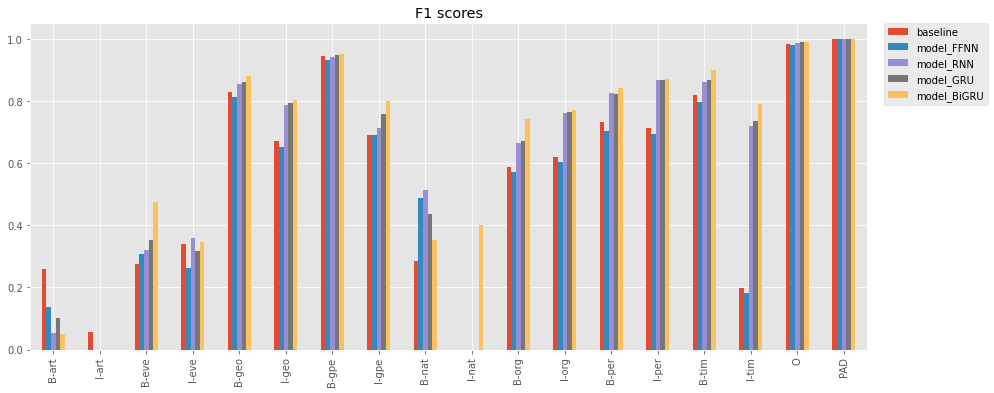

In [56]:
# your code here
# solution #
df = pd.DataFrame(groups)
df.columns = group_labels
df.index = model_names

ordered_cols = ['B-art','I-art','B-eve','I-eve','B-geo','I-geo','B-gpe',
                'I-gpe','B-nat','I-nat','B-org','I-org','B-per','I-per',
                'B-tim','I-tim','O','PAD']
df = df[ordered_cols]

ax = df.T.plot.bar(figsize=(15,6))
patches, labels = ax.get_legend_handles_labels()
_ = ax.legend(patches, labels, loc=1, bbox_to_anchor=(1.15, 1.015))
ax.set_title("F1 scores")

**3.3** Briefly discuss the performance of each model

*your answer here*

**Ranking of Models**

In general, the baseline model is the poorest performing, especially for tags that seldom appear or only appear moderately. But on some tags is does outperform The FFNN. The RNN then improves further still on the FFNN.

The GRU outperforms the RNN, and the bidirectional GRU outperforms the GRU.

**Results Unsurprising**

As we move from baseline to FFNN to RNN to GRU and to bidirectional GRU, we are moving from models that allow for simple relationships to models that allow for a more flexible range of relationships between words. Therefore, assuming that we have sufficient data, we should see an increase in performance (defined as increased F1 scores).

Tags that have high F1 scores uniformly across the models are probably tags associated with words that have a restricted range of contexts (in the simplest case, 'PAD' is only associated with one word 'ENDPAD' that is only used in one way as padding), and therefore even modelling the relationships simply will deliver good results.

However, for tags such as I-tim, it is likely that the tag is associated with words that inhabit multiple contexts, or multiple words, so more complex relationships will yield better results.

**Sometimes GRU is Worse**

For tags such as I-eve, the worse performance by GRU and bidirectional GRU even relative to the baseline suggests that we have insufficient data such that the more complex models have insufficient data to learn on and deliver better results.

**3.4** Which tags have the lowest f1 score? For instance, you may find from the plot above that the test accuracy on "B-art", and "I-art" are very low (just an example, your case maybe different). Here is an example when models failed to predict these tags right

*your answer here*

As we can see from the plot above, the F1 scores of the following tags are the lowest: I-nat, I-art, I-eve, and B-art. Their average F1 scores across all the models (less the poor performing baseline model) are decisively lower (below 0.16) compared to the rest of the tags.

**3.5** Write functions to output another example in which the tags of the lowest accuracy was predicted wrong in a sentence (include both "B-xxx" and "I-xxx" tags). Store the results in a DataFrame (same format as the above example) and use styling functions below to print out your df.

In [ ]:
def highlight_errors(s):
    is_max = s == s.y_true
    return ['' if v or key=='Word' else 'color: red' for key,v in is_max.iteritems()]

In [58]:
# your code here
model_names = ['baseline','model_FFNN','model_RNN', 'model_GRU', 'model_BiGRU']
predictions = {}

for model_name in model_names:
    
    print('Processing model {}'.format(model_name))
    
    if model_name=='baseline':
        y_hat = baseline[X_te]
    else:
        model = load_keras_model(model_name)
        y_hat = model.predict(X_te, batch_size=10)
        y_hat = np.argmax(y_hat, axis=-1)
    
    predictions[model_name] = y_hat
    
predictions['y_true'] = np.argmax(y_te, axis=-1)

Processing model baseline
Processing model model_FFNN
Processing model model_RNN
Processing model model_GRU
Processing model model_BiGRU


In [ ]:
# your code here
sentences_selection = []
tag_of_interest = 'I-art'

for idx_sentence in range(y_te.shape[0]): # for each sentence in test set
    sentence = predictions['y_true'][idx_sentence,:]
    if tag2idx[tag_of_interest] in sentence: # if it contains the tag of interest
        # find indexes of tag of interest in sentence
        idx_tag = np.where(sentence==tag2idx[tag_of_interest])[0]
        # check where models of interest does not work
        if (predictions['y_true'][idx_sentence,idx_tag]!=predictions["model_BiGRU"][idx_sentence,idx_tag]).all() and \
            (predictions['y_true'][idx_sentence,idx_tag]!=predictions["model_FFNN"][idx_sentence,idx_tag]).all():
            sentences_selection.append(idx_sentence)

In [60]:
# your code here
# Note: You must 'trust' the notebook to see the highlighting
# in a terminal you can run `jupyter trust cs109b_hw6_solution.ipynb`
idx_selected_sentence = 1
df_sentence = pd.DataFrame(np.column_stack(([idx2word[i] for i in X_te[sentences_selection[idx_selected_sentence],:]],
                                            [idx2tag[i] for i in predictions['y_true'][sentences_selection[idx_selected_sentence],:]])))
df_sentence.columns = ['Word','y_true']

for m in ['baseline','model_FFNN','model_RNN', 'model_GRU', 'model_BiGRU'] :
    df_sentence[m]=[idx2tag[i] for i in predictions[m][sentences_selection[idx_selected_sentence],:]]
                                           
df_sentence = df_sentence[df_sentence.Word != 'ENDPAD']
df_sentence.style.apply(highlight_errors, axis=1)

,Word,y_true,baseline,model_FFNN,model_RNN,model_GRU,model_BiGRU
0,On,O,O,O,O,O,O
1,Monday,B-tim,B-tim,B-tim,B-tim,B-tim,B-tim
2,",",O,O,O,O,O,O
3,American,O,B-gpe,B-gpe,B-gpe,B-gpe,B-gpe
4,Thomas,B-per,B-per,B-per,B-per,B-per,B-per
5,Schelling,I-per,I-per,O,I-per,I-per,I-per
6,and,O,O,O,O,O,O
7,Israeli-American,O,I-per,O,O,B-per,B-per
8,Robert,B-per,B-per,I-per,I-per,I-per,I-per
9,Aumann,I-per,I-per,I-per,I-per,I-per,I-per


**3.6** Choose one of the most promising models you have built, improve this model to achieve an f1 score higher than 0.8 for as many tags as possible (you have lots of options here, e.g. data balancing, hyperparameter tuning, changing the structure of NN, a different optimizer, etc.)

In [ ]:
# 3.6 and 3.7 answered together

**3.7** Explain why you chose to change certain elements of the model and how effective these adjustments were.

*your answer here*

In [62]:
# This and all further cells should be removed from student version
# from tf.keras.layers.merge import Add
# from tf.keras.models import Model,Input
# from keras.layers import Activation
# from keras import backend as K
# #K.tensorflow_backend._get_available_gpus()

tf.config.experimental.list_physical_devices('GPU')


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

### unnecessarily long sentences for X

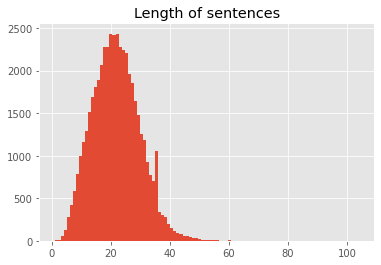

In [63]:
plt.hist([len(s) for s in sentences], bins=100)
plt.title("Length of sentences")
plt.show()

### re-padding to length=60

In [ ]:
max_len=60
# Prepare predictors list of lists
X = [[word2idx[w[0]] for w in s] for s in sentences]
# Apply the keras pad_sequences function
X = pad_sequences(maxlen=max_len, sequences=X, padding="post", value=n_words-1)
y = [[tag2idx[w[1]] for w in s] for s in sentences]
# Apply the kera pas_sequences function
y = pad_sequences(maxlen=max_len, sequences=y, padding="post", value=tag2idx["PAD"])


### Check data imbalance

In [65]:
data.Tag.value_counts()

O        887908
B-geo     37644
B-tim     20333
B-org     20143
I-per     17251
B-per     16990
I-org     16784
B-gpe     15870
I-geo      7414
I-tim      6528
B-art       402
B-eve       308
I-art       297
I-eve       253
B-nat       201
I-gpe       198
I-nat        51
Name: Tag, dtype: int64

### Split train and test, stratify minority groups

In [ ]:
def stratify_data(min_group):
    stratify_list=[]
    for tag in min_group:
        tag_set=set([int(str(v).split(" ")[-1]) for v in data[data.Tag==tag]["Sentence #"].values])
        stratify_list.append(tag_set)

    for i, tag_set in enumerate(stratify_list):
        stratify_list[i]=stratify_list[i]-stratify_list[i-1]

    union=set()
    for i in stratify_list:
        union=union|i
    dif=set(range(len(X)))-union

    train_idx=[]
    test_idx=[]
    for tag_set in stratify_list:
        tr,te=train_test_split(list(tag_set),test_size=0.1)
        train_idx+=(tr)
        test_idx+=(te)
    tr,te=train_test_split(list(dif),test_size=0.1)
    train_idx+=(tr)
    test_idx+=(te)

    X_tr=X[train_idx]
    X_te=X[test_idx]
    y_tr=y[train_idx]
    y_te=y[test_idx]
    y_tr=np.array([to_categorical(i, num_classes=n_tags) for i in y_tr])
    y_te=np.array([to_categorical(i, num_classes=n_tags) for i in y_te])
    
    return (X_tr,X_te,y_tr,y_te),union

### Boost sample weights

In [ ]:
base=data.Tag.value_counts()[1]
def boost_weight(min_group,union):
    new_weight={}
    for tag in min_group:
        new_weight[tag]=base//data.Tag.value_counts()[tag]*10

    weight=[1 for i in range(len(X_tr))]
    for i,w in enumerate(weight):
        for tag in min_group:
            if i in union:
                weight[i]=(new_weight[tag])
                break
    weight=np.array(weight)
    return weight

In [ ]:
target_group=["I-gpe","I-tim","I-geo"]
(X_tr,X_te,y_tr,y_te),union=stratify_data(target_group)
weight=boost_weight(target_group,union)

### custom metrics

In [ ]:
from tensorflow.keras import backend as K

In [ ]:
def f1_tensor(y_true, y_pred):
    y_true=K.reshape(y_true,(-1,18))
    y_pred=K.reshape(y_pred,(-1,18))

    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.math.is_nan(f1), tf.zeros_like(f1), f1)
    return f1

In [ ]:
# mean f1 score
def f1(y_true, y_pred):
    f1=f1_tensor(y_true, y_pred)
    return K.mean(f1)

In [ ]:
# number of tags with f1 score > 0.8
def ntag_80(y_true, y_pred):
    f1=f1_tensor(y_true, y_pred)
    return K.sum(K.cast((f1>0.8),'float'))

### custom loss function

In [ ]:
# maximize number of tags with f1 score > 0.8
def f1_loss(y_true, y_pred):
    f1=f1_tensor(y_true, y_pred)
    # give up the hopeless tags
    mask=np.array([False,False,True,True,False,True,True,True,False,False,True,True,False,True,True,True,False,False])
    f1=tf.boolean_mask(f1, mask)
    return K.sum(K.clip((0.8-f1),0,0.8))

In [ ]:
# improve overall f1 scores
def f1_loss_sum(y_true, y_pred):
    f1=f1_tensor(y_true, y_pred)
    return K.sum(1-f1)

### Model

(borrowed from https://github.com/ypwhs/baiduyun_deeplearning_competition, in essence the Bidirectional GRU)

In [ ]:
# Define model
input_tensor = tf.keras.layers.Input(shape=(max_len,))
x = input_tensor
x = tf.keras.layers.Embedding(input_dim=n_words, output_dim=1024, input_length=max_len)(x)
x = tf.keras.layers.Dense(n_units, kernel_initializer='he_uniform')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation('relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)

gru_1 = tf.keras.layers.GRU(n_units, return_sequences=True, kernel_initializer='he_uniform', name='gru1')(x)
gru_1b = tf.keras.layers.GRU(n_units, return_sequences=True, kernel_initializer='he_uniform', 
             go_backwards=True, name='gru1_b')(x)
x = tf.keras.layers.add([gru_1, gru_1b])

gru_2 = tf.keras.layers.GRU(n_units, return_sequences=True, kernel_initializer='he_uniform', name='gru2')(x)
gru_2b = tf.keras.layers.GRU(n_units, return_sequences=True, kernel_initializer='he_uniform', 
             go_backwards=True, name='gru2_b')(x)
x = tf.keras.layers.concatenate([gru_2, gru_2b])

x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(n_tags, activation='softmax')(x)

model = tf.keras.Model(inputs=input_tensor, outputs=x)

### First, train a few epochs to reach a reasonable accuracy

In [98]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 60)]         0                                            
__________________________________________________________________________________________________
embedding_6 (Embedding)         (None, 60, 1024)     36023296    input_2[0][0]                    
__________________________________________________________________________________________________
dense_6 (Dense)                 (None, 60, 100)      102500      embedding_6[0][0]                
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 60, 100)      400         dense_6[0][0]                    
____________________________________________________________________________________________

In [ ]:
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=6)
mc = tf.keras.callbacks.ModelCheckpoint('models/final_model.h5', monitor='val_loss', mode='min', save_best_only=True)

In [100]:
# Compile model
epochs = 60
model.compile(optimizer=optimizer, loss=loss, metrics=['acc'])

# Train model
model.fit(X_tr, y_tr, batch_size=batch_size, epochs=epochs, 
        validation_split=validation_split,
        sample_weight=weight,
        callbacks=[es, mc],
        verbose=1)

Epoch 1/60
1214/1214 [==============================] - 173s 142ms/step - loss: 42.4465 - acc: 0.9725 - val_loss: 23.2990 - val_acc: 0.9823
Epoch 2/60
1214/1214 [==============================] - 171s 141ms/step - loss: 19.3798 - acc: 0.9836 - val_loss: 20.6794 - val_acc: 0.9848
Epoch 3/60
1214/1214 [==============================] - 170s 140ms/step - loss: 14.6948 - acc: 0.9861 - val_loss: 19.3367 - val_acc: 0.9860
Epoch 4/60
1214/1214 [==============================] - 167s 138ms/step - loss: 12.2978 - acc: 0.9874 - val_loss: 20.8319 - val_acc: 0.9855
Epoch 5/60
1214/1214 [==============================] - 167s 138ms/step - loss: 10.6427 - acc: 0.9884 - val_loss: 20.2761 - val_acc: 0.9862
Epoch 6/60
1214/1214 [==============================] - 168s 138ms/step - loss: 9.5038 - acc: 0.9890 - val_loss: 20.0921 - val_acc: 0.9860
Epoch 7/60
1214/1214 [==============================] - 168s 138ms/step - loss: 8.3296 - acc: 0.9892 - val_loss: 19.8654 - val_acc: 0.9864
Epoch 00007: early sto

### Then train with f1_loss, and smaller learning rate

In [106]:
# Compile model
model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=0.0001),loss=[f1_loss], metrics=[ntag_80,f1])

# Train model
model.fit(X_tr, y_tr, batch_size=batch_size, epochs=epochs, 
        validation_split=validation_split,
        sample_weight=weight,
        callbacks=[es, mc],
        verbose=1)

Epoch 1/60
1214/1214 [==============================] - 169s 139ms/step - loss: 420.7973 - ntag_80: 8.5502 - f1: 0.5388 - val_loss: 492.6816 - val_ntag_80: 7.3333 - val_f1: 0.5181
Epoch 2/60
1214/1214 [==============================] - 168s 138ms/step - loss: 396.1798 - ntag_80: 9.0494 - f1: 0.5485 - val_loss: 480.9264 - val_ntag_80: 7.5185 - val_f1: 0.5213
Epoch 3/60
1214/1214 [==============================] - 169s 139ms/step - loss: 388.9696 - ntag_80: 9.2521 - f1: 0.5519 - val_loss: 477.7025 - val_ntag_80: 7.6074 - val_f1: 0.5227
Epoch 4/60
1214/1214 [==============================] - 168s 138ms/step - loss: 374.3510 - ntag_80: 9.3970 - f1: 0.5561 - val_loss: 472.4979 - val_ntag_80: 7.7259 - val_f1: 0.5241
Epoch 5/60
1214/1214 [==============================] - 168s 138ms/step - loss: 370.5055 - ntag_80: 9.5264 - f1: 0.5587 - val_loss: 470.4997 - val_ntag_80: 7.7407 - val_f1: 0.5243
Epoch 6/60
1214/1214 [==============================] - 168s 139ms/step - loss: 363.0262 - ntag_80: 

###  Results after many more epochs...

In [ ]:
model=load_keras_model('models/final_model.h5')

In [ ]:
y_hat = model.predict(X_te, batch_size=10)

f1_scores = f1_score(np.argmax(y_te,axis=-1).reshape(-1), 
                     np.argmax(y_hat,axis=-1).reshape(-1), 
                     average=None)

In [ ]:
print("Number of tags with f1 score higher than 0.8: ")
print(sum(f1_scores>0.8))

Text(0.5, 1.0, 'F1 scores')

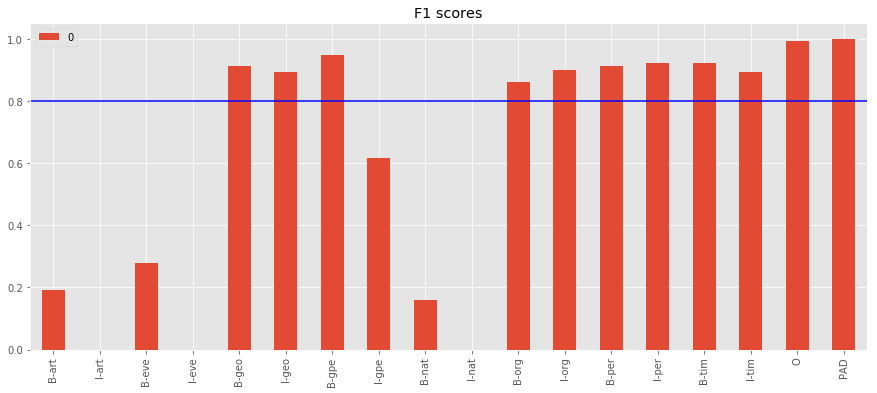

In [46]:
labels = [key for key,value in tag2idx.items()]
df = pd.DataFrame(f1_scores).T
df.columns = labels

ordered_cols = ['B-art','I-art','B-eve','I-eve','B-geo','I-geo','B-gpe',
                'I-gpe','B-nat','I-nat','B-org','I-org','B-per','I-per',
                'B-tim','I-tim','O','PAD']
df = df[ordered_cols]

ax = df.T.plot.bar(figsize=(15,6))
ax.hlines(0.8,-1,18,color='b')
ax.set_title("F1 scores")

If you want to increase overall f1 scores of all classes (instead of having more tags > 0.8), stratify and boost weights of minority groups, and use the loss function "f1_loss_sum" for training.